In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
def remove_bcs_outliers(donkeys):
    return donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4)] 

def remove_weight_outliers(donkeys):
    return donkeys[(donkeys['Weight'] >= 40)]

donkeys = (pd.read_csv('data/donkeys.csv')
           .pipe(remove_bcs_outliers)
           .pipe(remove_weight_outliers))

np.random.seed(42)
indices = np.arange(len(donkeys))
np.random.shuffle(indices)
n_train = int(np.round((len(donkeys)*0.8)))

train_set = donkeys.iloc[indices[:n_train]]
test_set = donkeys.iloc[indices[n_train:]]

# Modeling a Donkey's Weight

We want to build a simple model for predicting the weight of a donkey. The model should be easy for a vet to implement in the field with only a hand calculator. The model should also be easy to interpret.

We also want the model to depend on the vet's situation---for example, whether they're prescribing an antibiotic or an anesthetic.
For brevity, we only consider the case of prescribing an anesthetic.
Our first step is to choose a loss function that reflects this situation.

## A Loss Function for Prescribing Anesthetics

An overdose of an anesthetic can be much worse than an underdose. It's not hard
for a vet to see when a donkey has too little anesthetic (it'll complain), and
the vet can give the donkey a bit more. On the other hand, too much anesthetic
can have serious consequences and can even be fatal. Because of this, we want
an asymmetric loss function: it should have a bigger loss for an overestimate
of weight compared to an underestimate. This is in contrast to the other loss
functions that we have used so far in this book, which have all been symmetric. 

We've created a loss function `anes_loss(x)` with this in mind: 

In [3]:
def anes_loss(x):
    w = (x >= 0) + 3 * (x < 0)
    return np.square(x) * w

The relative error is $100(y - \hat{y})/\hat{y}$, where $y$ is the true value and $\hat{y}$ is the prediction. We can demonstrate the asymmetry of the loss function with a plot:

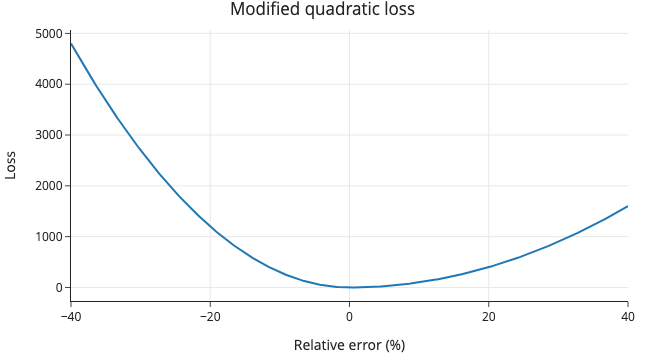

In [4]:
xs = np.linspace(-40, 40, 500)
loss = anes_loss(xs)

fig = px.line(x=xs, y=loss, title='Modified quadratic loss',
              width=350, height=250)

margin(fig, t=30)
xlabel(fig, 'Relative error (%)')
ylabel(fig, 'Loss')

Note that a value of –10 on the x-axis reflects an overestimate of 10%.

Next, let's fit a simple linear model using this loss function.

## Fitting a Simple Linear Model

We saw that girth has the highest correlation with weight among the donkeys in our train set. So we fit a model of the form: 

$$
\theta_0 + \theta_1 \text{Girth}
$$

To find the best fit $\theta_0$ and $\theta_1$ to the data, we first
create a design matrix that has girth and an intercept term.
We also create the $y$ vector of observed donkey weights:

In [5]:
X = train_set.assign(intr=1)[['intr', 'Girth']]
y = train_set['Weight']
X

,intr,Girth
230,1,116
74,1,117
354,1,123
...,...,...
157,1,123
41,1,103
381,1,106


Now we want to find the $\theta_0$ and $\theta_1$ that minimize the average anesthetic loss over the data. To do this, we could use calculus as we did in
{numref}`Chapter %s <ch:linear>`, but here we'll instead use the `minimize` method from the `scipy` package, which performs a numerical optimization (see {numref}`Chapter %s <ch:gd>`):

In [6]:
from scipy.optimize import minimize

def training_loss(X, y):
    def loss(theta):
        predicted = X @ theta
        return np.mean(anes_loss(100 * (y - predicted) / predicted))
    return loss

results = minimize(training_loss(X, y), np.ones(2))
theta_hat = results['x']

In [7]:
print('After fitting:')
print(f'θ₀ = {theta_hat[0]:>7.2f}')
print(f'θ₁ = {theta_hat[1]:>7.2f}')

After fitting:
θ₀ = -218.51
θ₁ =    3.16


Let's see how this simple model does. We can use the model to predict the
donkey weights on our train set, then find the errors in the predictions.
The residual plot that follows shows the model error as a percentage of the predicted
value. It's more important for the prediction errors to be small relative to
the size of the donkey, since a 10 kg error is much worse for a 100 kg
donkey than a 200 kg one. Thus, we find the relative error of each prediction:

In [9]:
predicted = X @ theta_hat
resids = 100 * (y - predicted) / predicted

Let's examine a scatter plot of the relative errors:

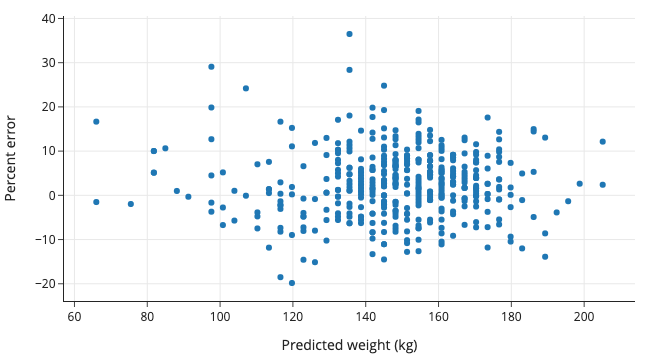

In [11]:
resid = pd.DataFrame({'Predicted weight (kg)': predicted, 'Percent error': resids})
px.scatter(resid, x='Predicted weight (kg)', y='Percent error',
           width=350, height=250)

With the simplest model, some of the predictions are off by 20% to 30%. Let's see if a slightly more complicated model improves the predictions. 

## Fitting a Multiple Linear Model 

Let's consider additional models that incorporate the other numeric variables.
We have three numeric variables that measure the donkey's girth, length, and
height, and there are seven total ways to combine these variables in a model:

In [12]:
import itertools

numeric_vars = ['Girth', 'Length', 'Height']

models = [list(subset)
          for n in [1, 2, 3]
          for subset in itertools.combinations(numeric_vars, n)]
models

[['Girth'],
 ['Length'],
 ['Height'],
 ['Girth', 'Length'],
 ['Girth', 'Height'],
 ['Length', 'Height'],
 ['Girth', 'Length', 'Height']]

For each of these variable combinations, we can fit a model with our special loss function.
Then we can look at how well each model does on the train set:

In [13]:
def training_error(model):
    X = train_set.assign(intr=1)[['intr', *model]]
    theta_hat = minimize(training_loss(X, y), np.ones(X.shape[1]))['x']
    predicted = X @ theta_hat
    return np.mean(anes_loss(100 * (y - predicted)/ predicted))

model_risks = [
    training_error(model)
    for model in models
]

In [12]:
pd.DataFrame({'model': models, 'mean_training_error': model_risks})

,model,mean_training_error
0,[Girth],94.36
1,[Length],200.55
2,[Height],268.88
3,"[Girth, Length]",65.65
4,"[Girth, Height]",86.18
5,"[Length, Height]",151.15
6,"[Girth, Length, Height]",63.44


As we stated earlier, the girth of the donkey is the single best predictor for weight. However, the combination of  girth and length has an average loss that is quite a bit smaller than girth alone, and this particular two-variable model is nearly as good as the model that includes all three. Since we want a simple model, we select the two-variable model over the three-variable one.

Next, we use feature engineering to incorporate categorical variables into the model, which improves our model.

## Bringing Qualitative Features into the Model

In our exploratory analysis, we found that the box plots of weight for donkey's body condition and age could contain useful information in predicting weight. 
Since these are categorical features, we can transform them to 0-1 variables with one-hot encoding, as explained in {numref}`Chapter %s <ch:linear>`.

One-hot encoding lets us adjust the intercept term in the model for each combination of categories. Our current model includes the numeric variables girth and length: 

$$
\theta_0 + \theta_1 \text{Girth} + \theta_2 \text{Length}
$$

If we cleaned up the age feature to consist of three categories---`Age<2`, `Age2-5`, and `Age>5`---a one-hot encoding of age creates three 0-1 features, one for each category. Including the one-hot encoded feature in the model gives:

$$
\begin{aligned}
    \theta_0
    & + \theta_1  \text{Girth }
      + \theta_2  \text{Length } \\
    & + \theta_3  \text{Age<2 }
      + \theta_4  \text{Age2-5 }
\end{aligned}
$$

In this model, 
`Age<2` is 1 for a donkey younger than 2 and 0 otherwise.
Similarly, `Age2-5` is 1 for a donkey between 2 and 5 years old and 0 otherwise.

We can think of this model as fitting three linear models that are 
identical except for the size of the constant, since the model
is equivalent to:

$$
\begin{aligned}
(\theta_0 + \theta_3 ) + \theta_1 \text{Girth} + \theta_2 \text{Length}
  & ~~~~~~~~~~\text{for a donkey under 2}\\
(\theta_0 + \theta_4 ) + \theta_1 \text{Girth} + \theta_2 \text{Length}
  & ~~~~~~~~~~\text{for a donkey between 2 and 4}\\
\theta_0  + \theta_1 \text{Girth} + \theta_2 \text{Length}
  & ~~~~~~~~~~\text{for a donkey over 5}
\end{aligned}
$$

Now let's apply a one-hot encoding to all three of our categorical variables
(body condition, age, and  sex):

In [14]:
X_one_hot = (
    train_set.assign(intr=1)
    [['intr', 'Length', 'Girth', 'BCS', 'Age', 'Sex']]
    .pipe(pd.get_dummies, columns=['BCS', 'Age', 'Sex'])
    .drop(columns=['BCS_3.0', 'Age_5-10', 'Sex_female'])
)
X_one_hot

,intr,Length,Girth,BCS_1.5,...,Age_<2,Age_>20,Sex_gelding,Sex_stallion
230,1,101,116,0,...,0,0,0,1
74,1,92,117,0,...,0,0,0,1
354,1,103,123,0,...,0,1,0,0
...,...,...,...,...,...,...,...,...,...
157,1,93,123,0,...,0,0,0,1
41,1,89,103,0,...,1,0,0,0
381,1,86,106,0,...,0,0,0,0


We dropped one dummy variable for each categorical feature.
Since `BCS`, `Age`, and `Sex` have six, six, and three categories, respectively,
we have added 12 dummy variables to the design matrix for a total of 15 columns,
including the intercept term, girth and length. 

Let's see which categorical variables, if any, improve on our two-variable model. To do this, we can fit the model that includes the dummies from all three categorical features, along with girth and length:

In [15]:
results = minimize(training_loss(X_one_hot, y), np.ones(X_one_hot.shape[1]))

theta_hat = results['x']

y_pred = X_one_hot @ theta_hat
training_error = (np.mean(anes_loss(100 * (y - y_pred)/ y_pred)))

print(f'Training error: {training_error:.2f}')

Training error: 51.47


According to average loss, this model does better than the previous model with only `Girth` and `Length`.
But let's try to make this model simpler while keeping its accuracy.
To do this, we look at the coefficients for each of the dummy variables to see how close they are to 0 and to one another. In other words, we want to see how much the intercept might change if we include the coefficients in the model.
A plot of the coefficients will make this comparison easy:

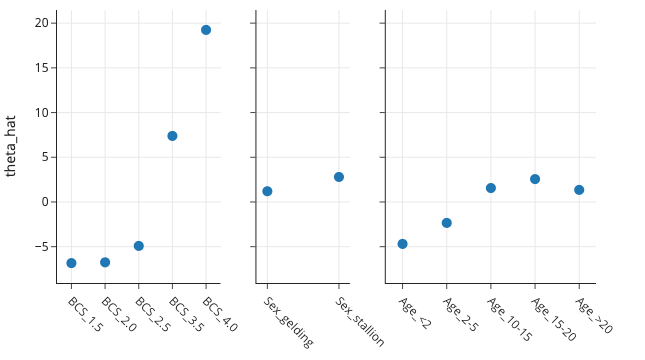

In [16]:
bcs_vars = ['BCS_1.5', 'BCS_2.0', 'BCS_2.5', 'BCS_3.5', 'BCS_4.0']
age_vars = ['Age_<2', 'Age_2-5', 'Age_10-15', 'Age_15-20', 'Age_>20']
sex_vars = ['Sex_gelding', 'Sex_stallion']

thetas = (pd.DataFrame({'var': X_one_hot.columns, 'theta_hat': theta_hat})
          .set_index('var'))

f1 = px.scatter(thetas.loc[bcs_vars].reset_index(), x='var', y='theta_hat')
f2 = px.scatter(thetas.loc[sex_vars].reset_index(), x='var', y='theta_hat')
f3 = px.scatter(thetas.loc[age_vars].reset_index(), x='var', y='theta_hat')

fig = plots_in_row([f1, f2, f3],
                   width=550, height=250,
                   shared_yaxes=True,
                   column_widths=[0.35, 0.2, 0.45])

ylabel(fig, 'theta_hat', row=1, col=1)
fig.update_xaxes(tickangle=45)
fig.update_traces(marker_size=10)

The coefficients confirm what we saw in the box plots. The coefficients for the
sex of the donkey are close to zero, meaning that knowing the sex doesn't
really change the weight prediction. We also see that combining the age
categories for donkeys over 5 years will simplify the model without losing
much. Lastly, since there are so few donkeys with a body condition score of 1.5 and its
coefficient is close to that of a BCS of 2, we are inclined to combine these
two categories. 

We update the design matrix in view of these findings:

In [17]:
def combine_bcs(X):
    new_bcs_2 = X['BCS_2.0'] + X['BCS_1.5']
    return X.assign(**{'BCS_2.0': new_bcs_2}).drop(columns=['BCS_1.5'])

def combine_age_and_sex(X):
    return X.drop(columns=['Age_10-15', 'Age_15-20', 'Age_>20',
                           'Sex_gelding', 'Sex_stallion'])

X_one_hot_simple = (
    X_one_hot.pipe(combine_bcs)
    .pipe(combine_age_and_sex)
)

And then we fit the simpler model:

In [18]:
results = minimize(training_loss(X_one_hot_simple, y),
                   np.ones(X_one_hot_simple.shape[1]))
theta_hat = results['x']
y_pred = X_one_hot_simple @ theta_hat
training_error = (np.mean(anes_loss(100 * (y - y_pred)/ y_pred)))
print(f'Training error: {training_error:.2f}')

Training error: 53.20


The average error is close enough to that of the more complex model for us to settle on this simpler one. Let's display the coefficients and summarize the model: 

In [19]:
thetas = pd.DataFrame({'var': X_one_hot_simple.columns, 'theta_hat': theta_hat})
display_df(thetas, 9)

,var,theta_hat
0,intr,-175.25
1,Length,1.01
2,Girth,1.97
3,BCS_2.0,-6.33
4,BCS_2.5,-5.11
5,BCS_3.5,7.36
6,BCS_4.0,20.05
7,Age_2-5,-3.47
8,Age_<2,-6.49


Our model is roughly:

$$
\text{Weight} \approx -175 + \text{Length} + 2\text{Girth}
$$

After this initial approximation, we use the categorical features to make some adjustments: 

+ BCS 2 or less? Subtract 6.5 kg. 
+ BCS 2.5? Subtract 5.1 kg. 
+ BCS 3.5? Add 7.4 kg.
+ BCS 4? Add 20 kg.
+ Age under 2 years? Subtract 6.5 kg.
+ Age between 2 and 5 years? Subtract 3.5 kg.

This model seems quite simple to implement because after our initial estimate based on the length and girth of the donkey, we add or subtract a few numbers based on answers to a few yes/no questions. Let's see how well the model does in predicting the weights of the donkeys in the test set. 

## Model Assessment

Remember that we put aside 20\% of our data before exploring and modeling with the remaining 80\%. We are now ready to apply what we have learned from the training set to the test set. That is, we take our fitted model and use it to predict the weights of the donkeys in the test set.
To do this, we need to prepare the test set. Our model uses the girth and length of the donkey, as well as dummy variables for the donkey's age and body condition score. We apply all of our transformations on the train set to our test set: 

In [20]:
y_test = test_set['Weight']

X_test = (
    test_set.assign(intr=1)
    [['intr', 'Length', 'Girth', 'BCS', 'Age', 'Sex']]
    .pipe(pd.get_dummies, columns=['BCS', 'Age', 'Sex'])
    .drop(columns=['BCS_3.0', 'Age_5-10', 'Sex_female'])
    .pipe(combine_bcs)
    .pipe(combine_age_and_sex)
)

We consolidate all of our manipulations of the design matrix to create the final version that we settled on in our modeling with the train set. Now we are ready to use the $\theta$s that we fitted with the train set to make weight predictions for those donkeys in the test set: 

In [21]:
y_pred_test = X_test @ theta_hat
test_set_error = 100 * (y_test - y_pred_test) / y_pred_test

Then we can plot the relative prediction errors:

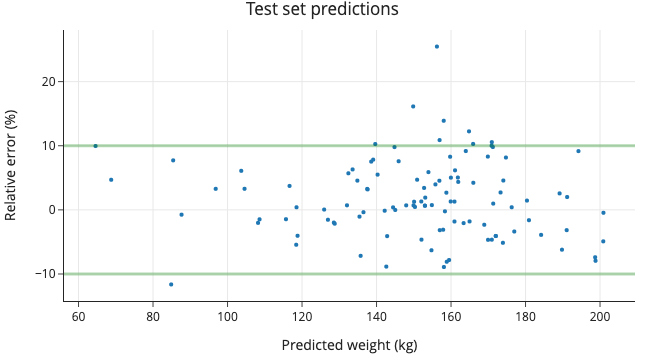

In [22]:
fig = px.scatter(x=y_pred_test, y=test_set_error,
                 title='Test set predictions',
                 width=350, height=250)
fig.update_traces(marker=dict(size=4))
fig.add_hline(10, line_width=3, line_color='green')
fig.add_hline(-10, line_width=3, line_color='green')
margin(fig, t=30)
xlabel(fig, 'Predicted weight (kg)')
ylabel(fig, 'Relative error (%)')

Remember that positive relative error means underestimating weight, which is not as critical as overestimating weight. From this residual plot, we see that
nearly all of the test set weights are within 10% of the predictions, 
and only one error that exceeds 10% errs on the side of overestimation.
This makes sense given that our loss function penalized overestimation more. 

An alternative scatter plot that shows the actual and predicted values along with lines marking 10% error gives a different view:

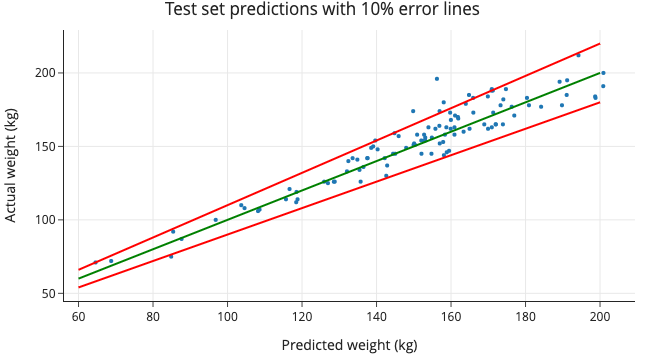

In [23]:
fig = px.scatter(y=y_test, x=y_pred_test, 
                 title="Test set predictions with 10% error lines",
                 width=350, height=350)
fig.update_traces(marker=dict(size=4))

fig.add_trace(go.Scatter(x=[60, 200], y=[60, 200], name='0% error',
                         mode='lines',
                         marker=dict(color='green')))
fig.add_trace(go.Scatter(x=[60, 200], y=[66, 220], name='10% error',
                         mode='lines',
                         marker=dict(color='red')))
fig.add_trace(go.Scatter(x=[60, 200], y=[54, 180], name='-10% error',
                         mode='lines',
                         marker=dict(color='red')))

fig.update_layout(showlegend=False)
xlabel(fig, "Predicted weight (kg)")
ylabel(fig, "Actual weight (kg)")
margin(fig, t=30)

The 10% lines lie farther from the prediction line for larger weights.

We've accomplished our goal!
We have a model that uses easy-to-get measurements, is simple enough to explain on an instruction sheet, and makes predictions within 10% of the actual donkey weight.
Next, we summarize this case study and reflect on our model.